In [5]:
#!pip3 install -q numpy pandas catboost hyperopt scikit-learn frozendict matplotlib

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [7]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [8]:
#Initial code used from https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/
 # and parameter search from https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html

import catboost as cb
import numpy as np
import numpy.random as nr
import pandas as pd
import catboost.utils as cbu
#import hyperopt
import sys
import sklearn.model_selection as ms

import sklearn.metrics as sklm

from frozendict import frozendict
%matplotlib inline

# print module versions for reproducibility
print('CatBoost version {}'.format(cb.__version__))
print('NumPy version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))

CatBoost version 0.15.2
NumPy version 1.16.2
Pandas version 0.24.2


In [12]:
# Load already prepared training dataset, display shape, & explore first 10 rows of Pandas data frame

train_set = pd.read_csv('LoanTrain_Clean_2019-06-29-A2e2a.csv')
print(train_set.shape)
train_set.head()

(500000, 37)


,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,dummy,log(x+1)_loan_amount,log(x+1)_LTI,log(x+1)_applicant_income,log(x+1)_population,log(x+1)_minority_population_pct,log(x+1)_ffiecmedian_family_income,log(x+1)_number_of_owner-occupied_units,log(x+1)_number_of_1_to_4_family_units,pwr10_tract_to_msa_md_income_pct
0,0,3,1,1,1,70.0,3,18,37,246,...,1.0,4.262680,1.365241,3.218876,8.732950,3.811761,11.011869,6.575076,7.879670,1.174877e+17
1,1,1,1,3,1,178.0,3,369,52,299,...,1.0,5.187386,1.416534,4.060443,8.661294,2.827609,10.911847,7.392032,7.653969,1.000000e+20
2,2,2,1,3,1,163.0,3,16,10,306,...,1.0,5.099866,1.233387,4.219508,8.715224,4.131480,11.123137,6.634633,6.955593,1.000000e+20
3,3,1,1,1,1,155.0,1,305,47,180,...,1.0,5.049856,0.906721,4.663439,8.805075,1.980450,11.270089,7.613819,7.740664,1.000000e+20
4,4,1,1,1,1,305.0,3,24,37,20,...,1.0,5.723585,1.666909,4.276666,8.814776,4.615121,11.052096,7.289611,7.521859,1.408375e+19


In [13]:
# Testing for Class Imbalance by Examining Classes where label= accepted
 # Unequal numbers of cases for the categories of labels, which can seriously bias the training of classifier alogrithms 
 #  higher error rate for the minority class. This should be tested for before training any model.   

train_set_counts = train_set[['loan_type','accepted']].groupby('accepted').count()
print(train_set_counts)

          loan_type
accepted           
0            249886
1            250114


In [16]:
#Load test data previously prepared in data preparation step.

test_set = pd.read_csv('LoanTest_Clean_2019-06-29-A2w2a.csv')
print(test_set.shape)
test_set.head()

(500000, 35)


,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,RaceGroup,log(x+1)_loan_amount,log(x+1)_LTI,log(x+1)_applicant_income,log(x+1)_population,log(x+1)_minority_population_pct,log(x+1)_ffiecmedian_family_income,log(x+1)_number_of_owner-occupied_units,log(x+1)_number_of_1_to_4_family_units,pwr10_tract_to_msa_md_income_pct
0,0,2,1,3,1,115.0,3,101,16,276,...,5,4.753590,0.937682,4.317488,8.753056,4.103238,11.154678,7.536364,7.787797,2.157051e+19
1,1,1,1,1,1,252.0,2,87,20,68,...,5,5.533389,1.210494,4.682131,7.813592,2.202765,11.086962,6.854355,7.102499,1.000000e+20
2,2,1,1,1,1,270.0,1,-1,-1,-1,...,1,5.602119,1.184456,4.787492,8.512382,3.176177,11.120105,7.190676,7.469654,1.000000e+20
3,3,2,1,1,1,179.0,2,376,20,11,...,2,5.192957,1.622982,3.806662,8.475538,3.423481,10.964173,7.263330,7.476472,1.000000e+20
4,4,2,1,1,1,36.0,2,254,48,156,...,6,3.610918,0.753772,3.496508,8.565412,1.809927,11.056162,7.281386,7.646354,1.000000e+20


In [17]:
# Check training data types

train_set.dtypes

row_id                                       int64
loan_type                                    int64
property_type                                int64
loan_purpose                                 int64
occupancy                                    int64
loan_amount                                float64
preapproval                                  int64
msa_md                                       int64
state_code                                   int64
county_code                                  int64
applicant_ethnicity                          int64
applicant_race                               int64
applicant_sex                                int64
applicant_income                           float64
population                                 float64
minority_population_pct                    float64
ffiecmedian_family_income                  float64
tract_to_msa_md_income_pct                 float64
number_of_owner-occupied_units             float64
number_of_1_to_4_family_units  

In [18]:
# Check test data types

test_set.dtypes

row_id                                       int64
loan_type                                    int64
property_type                                int64
loan_purpose                                 int64
occupancy                                    int64
loan_amount                                float64
preapproval                                  int64
msa_md                                       int64
state_code                                   int64
county_code                                  int64
applicant_ethnicity                          int64
applicant_race                               int64
applicant_sex                                int64
applicant_income                           float64
population                                 float64
minority_population_pct                    float64
ffiecmedian_family_income                  float64
tract_to_msa_md_income_pct                 float64
number_of_owner-occupied_units             float64
number_of_1_to_4_family_units  

In [19]:
#Creating a training set for modeling and validation set to check model performance


train_set = train_set.drop('accepted', axis=1) # remove labels

In [20]:
# ReCheck training data types

train_set.dtypes

row_id                                       int64
loan_type                                    int64
property_type                                int64
loan_purpose                                 int64
occupancy                                    int64
loan_amount                                float64
preapproval                                  int64
msa_md                                       int64
state_code                                   int64
county_code                                  int64
applicant_ethnicity                          int64
applicant_race                               int64
applicant_sex                                int64
applicant_income                           float64
population                                 float64
minority_population_pct                    float64
ffiecmedian_family_income                  float64
tract_to_msa_md_income_pct                 float64
number_of_owner-occupied_units             float64
number_of_1_to_4_family_units  

In [21]:
# ReCheck test data types

test_set.dtypes

row_id                                       int64
loan_type                                    int64
property_type                                int64
loan_purpose                                 int64
occupancy                                    int64
loan_amount                                float64
preapproval                                  int64
msa_md                                       int64
state_code                                   int64
county_code                                  int64
applicant_ethnicity                          int64
applicant_race                               int64
applicant_sex                                int64
applicant_income                           float64
population                                 float64
minority_population_pct                    float64
ffiecmedian_family_income                  float64
tract_to_msa_md_income_pct                 float64
number_of_owner-occupied_units             float64
number_of_1_to_4_family_units  

In [22]:
# Now, you’ll see that we will only identify categorical variables. We will not perform any preprocessing steps for 
 # categorical variables:

categorical_features_indices = np.where(train_set.dtypes != np.float)[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 20, 21, 24, 25])

In [24]:
# Convert datasets to numpy arrays
 # Load training labels

train_set = np.array(train_set)
test_set = np.array(test_set)

l = pd.read_csv('train_labels.csv')
labels = np.array(l['accepted'])
print(labels.shape)
labels[:5]

(500000,)


array([1, 0, 1, 1, 1])

In [25]:
# Check labels

print(labels)

[1 0 1 ... 0 0 0]


In [26]:
# Creating a training set for modeling and validation set to check model performance

nr.seed(1115)   # Randomly sample cases to create independent training & test data
indx = range(train_set.shape[0])
indx = ms.train_test_split(indx, test_size = 150000)
x_train = train_set[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_validation = train_set[indx[1],:]
y_validation = np.ravel(labels[indx[1]])

In [27]:
# Check validation set

print(y_validation)

[0 0 1 ... 0 1 1]


In [28]:
# Create prediction set

x_predict = test_set

In [29]:
# Check prediction set

print(y_validation)

[0 0 1 ... 0 1 1]


In [30]:
class HLClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=20181224,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [31]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'depth': hyperopt.hp.randint('depth', 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10)}
    objective = HLClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=20181224))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=categorical_features_indices)
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
            
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [33]:
# make it True if your want to use GPU for training
import time
start=time.time()
import hyperopt

have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50

const_params = frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 100,
    'random_seed': 20181224})

model, params = train_best_model(
    x_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)
end = time.time()
print(end-start)

evaluating params={'learning_rate': 0.8370106458894697, 'depth': 0, 'l2_leaf_reg': 8.835837790286535, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.5                                 
evaluated 1 times                                   
evaluating params={'learning_rate': 0.8414600898588487, 'depth': 3, 'l2_leaf_reg': 3.841780975474402, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7191331646763076                               
evaluated 2 times                                                
evaluating params={'learning_rate': 0.4234185321620083, 'depth': 5, 'l2_leaf_reg': 9.464266235679002, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7522499406851715  

evaluated score=0.7396890571420087                                                  
evaluated 21 times                                                                  
evaluating params={'learning_rate': 0.3548362548720143, 'depth': 6, 'l2_leaf_reg': 2.683829844728577, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.75898963971037                                                    
evaluated 22 times                                                                  
evaluating params={'learning_rate': 0.34157254294917927, 'depth': 2, 'l2_leaf_reg': 5.898356054606159, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.706028304452269                                                   
evaluated 23 times                                                                  
evalu

evaluated score=0.7589896416695763                                                
evaluated 41 times                                                                
evaluating params={'learning_rate': 0.5797660073534159, 'depth': 4, 'l2_leaf_reg': 7.441714806378932, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.7396890571420087                                                
evaluated 42 times                                                                
evaluating params={'learning_rate': 0.7243213901349814, 'depth': 1, 'l2_leaf_reg': 8.562606711737995, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}
evaluated score=0.6594692097881453                                                
evaluated 43 times                                                                
evaluating params=

In [34]:
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    
    dataset = cb.Pool(X, y, cat_features=categorical_features_indices)
    fpr, tpr, _ = cbu.get_roc_curve(model, dataset)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    pl.figure(figsize=(8, 8,))
    pl.plot(fpr, tpr)
    pl.xlim([-0.1, 1.1])
    pl.ylim([-0.1, 1.1])
    pl.xlabel('FPR')
    pl.ylabel('TPR')
    pl.title('ROC curve (AUC={:.3f})'.format(auc))
    pl.show()
    
    return auc

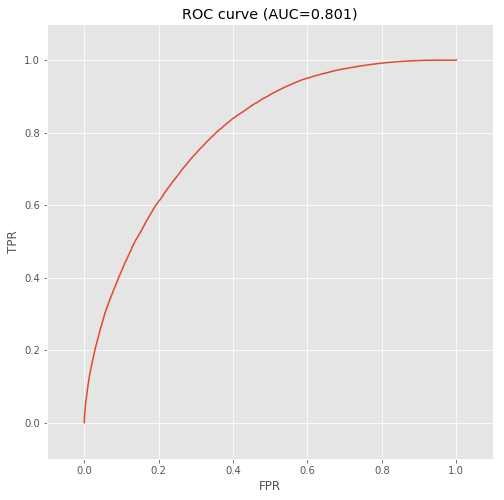

0.8006667438597032

In [35]:
calculate_score_on_dataset_and_show_graph(x_validation, y_validation, model)


In [44]:
#Above- AUC = 0.807

#Below- Compute & display sample of class probabilities for test feature data set.
 # Class w/ highest probability is taken as score (prediction)
    
probabilities = model.predict_proba(data=x_validation)
print(probabilities[:15, :])

[[0.35820914 0.64179086]
 [0.26202473 0.73797527]
 [0.71506544 0.28493456]
 [0.2532457  0.7467543 ]
 [0.32070098 0.67929902]
 [0.6204458  0.3795542 ]
 [0.31330456 0.68669544]
 [0.5294793  0.4705207 ]
 [0.38318251 0.61681749]
 [0.81924206 0.18075794]
 [0.9182941  0.0817059 ]
 [0.21227542 0.78772458]
 [0.22267179 0.77732821]
 [0.91485656 0.08514344]
 [0.25987947 0.74012053]]


In [45]:
#Above- 1st column= probability of score 0, 2nd column= prob of score 1.

#Below- Transform class probabilities into class scores.
 # Set threshold to prob b/w 2 likelihoods at 0.5. This is applied to prob of score 0 below.
    
def score_model(probs, threshold):
    return np.array([1 if x> threshold else 0 for x in probs[:, 1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_validation[:15])

[1 1 0 1 1 0 1 0 1 0 0 1 1 0 1]
[0 0 1 0 1 0 1 0 1 0 0 0 1 0 0]


In [46]:
# ReCheck accuracy by the equal provided by DrivenData

N = len(y_validation)
print(N)

def isEqual(a):
    return a[0] == a[1]

ClRt = (1/N)*sum(1 for i in filter(isEqual, zip(scores, y_validation)))
print(ClRt)

150000
0.7226133333333333


In [47]:
import sklearn.metrics as sklm

#Below- Compute a confusion matrix as a metric to evaluate the results for the logisitic regression model
 #True Positive (TP)- cases w/ positive labels which have been correctly classified as positive
 #True Negative (TN)- cases w/ negative labels which have been correctly classified as negative
 #False Positive (FP)- cases w/ negative labels which have been incorrectly classified as positive
 #False Negative (FN)- cases w/ positive labels which have been incorrectly classified as negative
 # where positive is 1 and neagtive is 0
    
 #Accuracy/Bias- fraction of cases correctly classified
 #Precision- fraction of correctly calssified label cases out of all cases classified w/ that label value
   # is sentistive to the # of cases correctly classified for a given score value
 #Recall- fraction of cases of a label value correctly classified out of all cases for that have that label value
   # is sensitive to the # of cases correctly classified for a given true label value
 #F1- weighted average of precision and recall (overall model performance)
 #ROC- (receiver operating characteristic) displays relationship b/w TP rate on y and FP rate on x
 #AUC- (area/integral under the curve) overall performance of classifer model
   # higher the AUC, the lower the increase in FP rate req to achieve a req TP rate
     # Ideally AUC= 1.0, TP rate is achieved w/ 0 FP rate.
     # can compare classifiers, one w/ higher AUC is generally better
     # ROC diagonal for Bernoulli w/ AUC 0.5, anything greater than this is better than random guessing in balanced cases
    
#Below- Compute & examine the performance metrics for the classifier using precision_recall_fscore_support 
 # & accuracy_score functions from metric package in scikit-learn. Confusion matrix is computed through 
 # confusion_matrix from same package.

def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion Matrix ')
    print('                 Score Positive     Score Negative ')
    print('Actual Positive    %6d' % conf[0, 0] + '              %5d' % conf[0, 1])
    print('Actual Negative    %6d' % conf[1, 0] + '              %5d' % conf[1, 1])
    print('')
    print('Accuracy   %0.2f' % sklm.accuracy_score(labels, scores))
    print('')
    print('            Positive     Negative')
    print('Num Case    %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision   %6.2f' % metrics[0][0] + '        %6.2f' % metrics [0][1])
    print('Recall      %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1          %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][0])
    
    
print_metrics(y_validation, scores)

                 Confusion Matrix 
                 Score Positive     Score Negative 
Actual Positive     49746              25208
Actual Negative     16400              58646

Accuracy   0.72

            Positive     Negative
Num Case     74954         75046
Precision     0.75          0.70
Recall        0.66          0.78
F1            0.71          0.71


In [55]:
# Get Feature Importances

model.get_feature_importance(prettified=True)




,Feature Index,Importances
0,20,27.525422
1,9,18.211117
2,8,8.873865
3,3,7.101839
4,23,6.119038
5,13,5.002330
6,6,3.562846
7,28,3.483538
8,29,2.203687
9,5,2.096093


In [58]:
# Score & display performance metrics for test dataset model

import sklearn.metrics as sklm

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion Matrix')
    print('                 Score Positive    Score Negative')
    print('Actual Positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual Negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro Precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro Recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num Case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
    
probabilities = model.predict_proba(x_validation)
print_metrics(y_validation, probabilities, 0.5)     

                 Confusion Matrix
                 Score Positive    Score Negative
Actual Positive     49746             25208
Actual Negative     16400             58646

Accuracy        0.72
AUC             0.80
Macro Precision 0.73
Macro Recall    0.72
 
           Positive      Negative
Num Case    74954         75046
Precision    0.75          0.70
Recall       0.66          0.78
F1           0.71          0.74
